Prédiction consommation
=======================

##  Introduction

Ce fichier permet de générer un modèle de prédiction pour la consommation d'énergie.  

## 1. Traitement des données

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


#### 1) Chargement des données sous forme csv

In [2]:
df = pd.read_csv('pypeper/data/6mois.csv', 
              usecols=[0, 1, 6, 7, 8], index_col=0, parse_dates=True, nrows=22000)
df.keys()

Index(['Air Temperature (ºC)', 'Total electricity consumption (kW)',
       'Zone1 electricity consumption (kW)',
       'Zone2 electricity consumption (kW)'],
      dtype='object')

#### 1) bis. Réechantillonnage

In [3]:
df = df.resample('15Min').mean()

#### 2) Préparation des données
A partir de la date (colonne 0 des données), nous créons les nouveaux features : day of the week, day of the year, hour of the day , etc. 
    

In [4]:
df['day of the week'] = df.index.dayofweek
df['day of the year'] = df.index.dayofyear
df['hour of the day'] = df.index.hour
df['number of the week'] = df.index.weekofyear
df['minute of the hour'] = df.index.minute

#### 3) Selection des features et des labels

Après avoir charger et modifier les données, il est possible de séléctionner les features et les labels comme suit:

In [5]:
features = ['day of the week', 'hour of the day', 'minute of the hour', 'Air Temperature (ºC)', 'number of the week']
labels   = ['Total electricity consumption (kW)', 'Zone1 electricity consumption (kW)']
inputs   = features + labels
df = df[inputs]

num_features = len(features)
num_labels = len(labels)
num_inputs = num_features + num_labels

* Normalisation des données

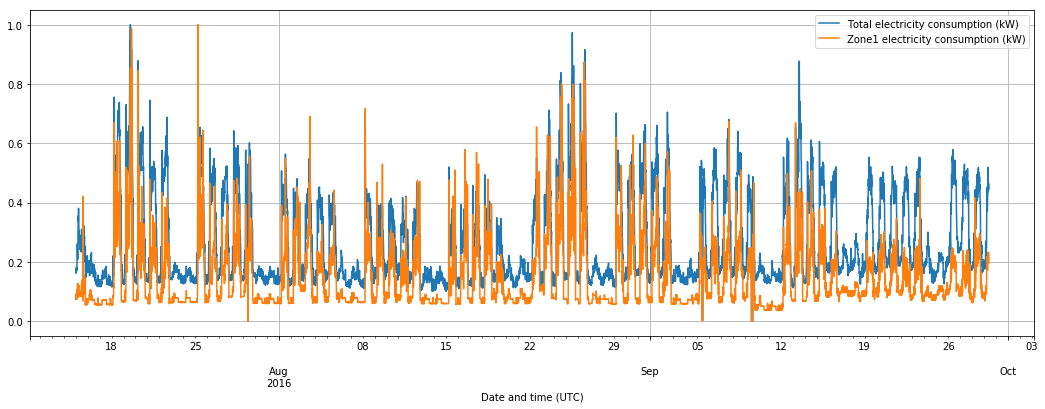

In [6]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
df_scaled[labels].plot(ax=ax)
plt.grid(True)
plt.show()

* Crétion des données d'apprentissage et de test

In [7]:
def split_data(data, test_size=0.25):
    """
    splits data to training and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    
    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]
    
    return df_train, df_test


Longueur totale des données: 			7334
Longueur totale des données de test  : 		1834
Longueur totale des données d"apprentissage : 	5500


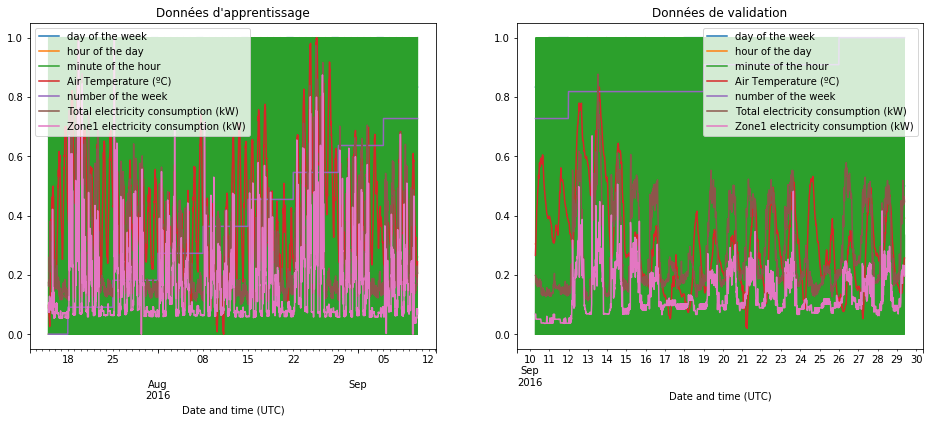

In [8]:
df_train, df_test = split_data(df_scaled, test_size=0.25)

x_train_scaled = np.asarray(df_train[features])
x_test_scaled = np.asarray(df_test[features])
y_test_scaled = np.asarray(df_test[labels])
y_train_scaled = np.asarray(df_train[labels])

num_test = len(df_test)
num_train = len(df_train)
num_total = len(df)

print(f'Longueur totale des données: \t\t\t{len(df)}\n'+
f'Longueur totale des données de test  : \t\t{len(df_test)}\n'+
f'Longueur totale des données d"apprentissage : \t{len(df_train)}')

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_train.plot(ax=ax1, title="Données d'apprentissage")
df_test.plot(ax=ax2, title="Données de validation")

Fonction pour la création des batch de test et de validation 

In [9]:
def batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x, y):
    """
    Generator function for creating random batches of training-data.
    """

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_labels)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
   
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if num_test<sequence_length:
                print("there will be a problem test too short", num_test)
            idx = np.random.randint(num_test - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x[idx:idx+sequence_length]
            y_batch[i] = y[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)


* Creation de la matrice Batch, de taille batch_size x sequence_lenth x num_inputs

C'est à dire une matrice qui contient batch_size échantillons de taille sequence_lenth, par exemple 2 jours, et ce pour toute les entrés (jour de la semaine, heure du jour, etc.).

X Batch Shape :  (50, 96, 5)
Y Batch Shape :  (50, 96, 5)


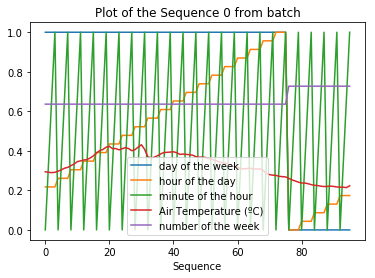

In [10]:
batch_size = 50             
sequence_length = int(60/15*24*1)  

generator     = batch_generator(batch_size, sequence_length, num_features, 
                                num_labels, num_train, x_train_scaled, y_train_scaled)
testgenerator = batch_generator(batch_size, sequence_length, num_features, 
                                num_labels, num_test,  x_test_scaled,  y_test_scaled)

x_batch, y_batch = next(generator)

print(f'X Batch Shape :  {x_batch.shape}')
print(f'Y Batch Shape :  {x_batch.shape}')

seq = x_batch[0, :, :]
plt.plot(seq)
plt.xlabel('Sequence')
plt.legend(features)
plt.title(f'Plot of the Sequence 0 from batch')
plt.show()

## 2. Création du modèle de prédiction

On choisis ici un modèle de type _dynamique recurrent neural network_ (dynamic_rnn). Avec _num layer_ cellules de type LTSM et une couche dense. La fonction d'optimisation étant _tf.losses.mse_, i.e. the mean square error. 

In [15]:
from tensorflow.keras.utils import Progbar

num_neurons = 100  # was 10
learning_rate = 0.001
num_layers = 4
num_iter = 500
keep_prob = 0.2

next(testgenerator)
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32, [None, sequence_length, num_features], name="x")
    y = tf.placeholder(tf.float32, [None, sequence_length, num_labels], name="y") 

    def get_a_cell(lstm_size, keep_prob):
            lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
            drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            return drop
    
    # def get_a_cell(num_neurons, dropout):
    #         return tf.contrib.cudnn_rnn.CudnnLSTM(num_layers, num_neurons, dropout=dropout)
    #     
    with tf.name_scope('lstm'):
        cell = tf.nn.rnn_cell.MultiRNNCell([get_a_cell(num_neurons, 1-keep_prob) for _ in range(num_layers)])

    # cell = tf.contrib.cudnn_rnn.CudnnLSTM(num_layers, num_neurons, dropout=1-keep_prob)
    
    outputs, current_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

    # from another program 
    stacked_rnn_output = tf.reshape(outputs, [-1, num_neurons])           #change the form into a tensor
    stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels)        #specify the type of layer (dense)
    outputs = tf.reshape(stacked_outputs, [-1, sequence_length, num_labels])          #shape of results

    loss = tf.losses.mean_squared_error(y, outputs)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
     
    train = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        sess.run(init)
        histogram_summary = tf.summary.scalar('MSE', loss)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('./graphs', sess.graph)
        progbar = Progbar(num_iter)
        
        for iter in range(num_iter):
            x_batch, y_batch = next(generator)
            _current_state, l = sess.run([current_state, train], feed_dict={x: x_batch, y: y_batch})
            histogram_summary = tf.summary.histogram('My_histogram_summary', loss)
            res_sum = sess.run(merged, feed_dict={x: x_batch, y: y_batch})   
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
            writer.add_summary(res_sum, iter)
            progbar.update(iter, values=[('MSE', mse)])
                            
        x_btest, ybtest = next(testgenerator)
        y_pred = sess.run(outputs, feed_dict={x: x_btest})
        
        ind = (len(x_test_scaled)//(sequence_length))*sequence_length
        x_test_tensor = x_test_scaled[0:ind].reshape([-1, sequence_length, num_features])
        y_model = sess.run(outputs, feed_dict={x: x_test_tensor})
        

499/500 [============================>.] - ETA: 0s - MSE: 0.0075

#### Inverse transformation and plot prediction on test data

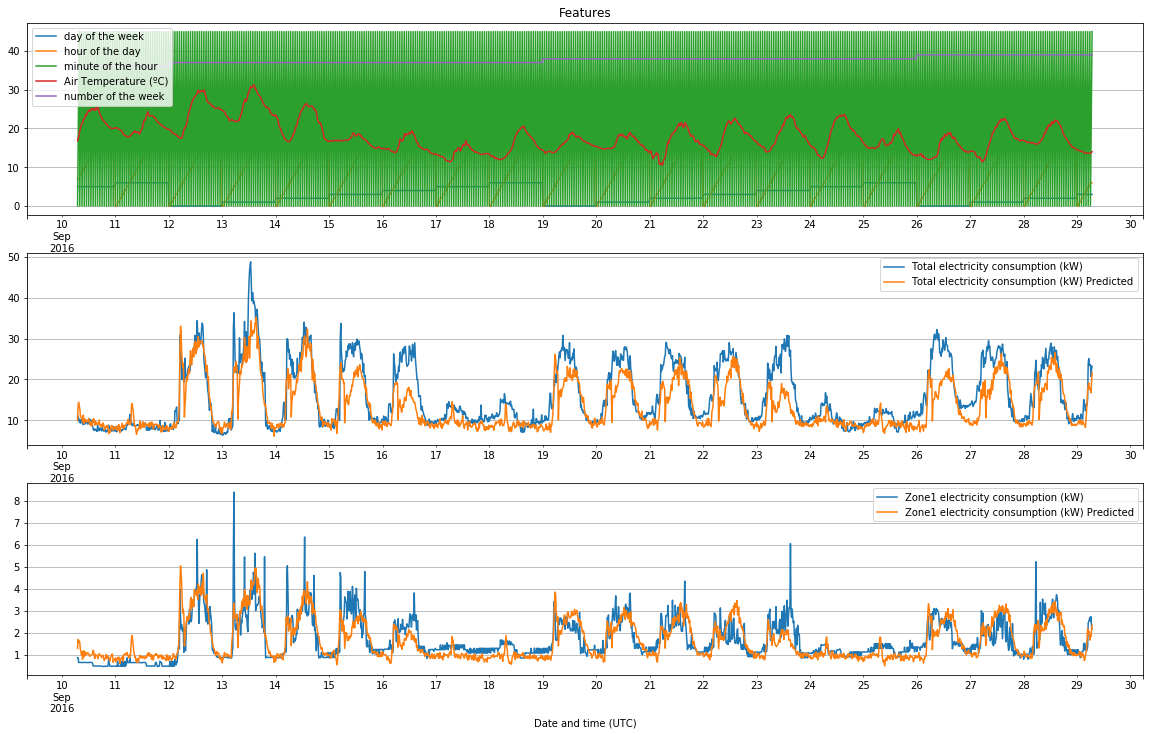

In [26]:
y_test = y_model.reshape(-1, num_labels)

scaler.fit(df[labels])
DF = pd.DataFrame(scaler.inverse_transform(y_test), index=df_test.iloc[0:ind].index, columns=labels)

fig = plt.figure(figsize=(20, 12))

ax = fig.add_subplot(311)
df[features].loc[DF.index].plot(ax=ax)
plt.grid()
plt.title('Features')

ax = fig.add_subplot(312)
df[labels[0]].loc[DF.index].plot(ax=ax)
DF[labels[0]].plot(ax=ax, label=labels[0]+' Predicted')
plt.legend()
plt.grid()

ax = fig.add_subplot(313)
df[labels[1]].loc[DF.index].plot(ax=ax)
DF[labels[1]].plot(ax=ax, label=labels[1]+' Predicted')
plt.legend()
plt.grid()
